# NASA Near Earth Objects Data Analysis

This code creates a database containing the information of the closest approach asteroids within a date range (Note that the maximum date range is 7 days). It retrieves the data using NASA API, Near Earth Object web service (Neo-Feed). Then, it stores some of the information about the retrieved asteroids in a database using SQLite. The inserted asteroid's information is as follows: object ID, min estimated diameter (meter), max estimated diameter (meter), close approach date (YYY-MM-DD), distance (lunar), relative velocity (km/s) and orbiting body. Next, it performs statistical analysis such as calculating the mean, variance, coefficient of variation and entropy of the data. Also, it plots the histogram, kernel-estimated probability distribution function, box plot, scatter matrix and pie chart of the data. 

Import required libraries:

In [1]:
import urllib
import json
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm

NASA Neo-Feed API and personal key:

In [2]:
serviceurl = 'https://api.nasa.gov/neo/rest/v1/feed?'
apiKey = 'fgz6lemvwyEkrBF2GIdZjFfFh52zojqISTeK9yC7'

Ask users to input start and end dates:

In [3]:
startDate = raw_input('Please enter start date (YYYY-MM-DD): ')
endDate = raw_input('Please enter end date (YYYY-MM-DD): ')

Please enter start date (YYYY-MM-DD): 2016-10-01
Please enter end date (YYYY-MM-DD): 2016-10-08


Retrieve the URL and asteroid data within the requested date range using NASA API:

In [4]:
url = serviceurl + urllib.urlencode({'start_date': startDate, 'end_date': endDate, 'api_key': apiKey})
print 'Retrieving', url
uh = urllib.urlopen(url)
data = uh.read()

Retrieving https://api.nasa.gov/neo/rest/v1/feed?api_key=fgz6lemvwyEkrBF2GIdZjFfFh52zojqISTeK9yC7&start_date=2016-10-01&end_date=2016-10-08


Load json data in a dictionary format:

In [6]:
js = json.loads(str(data))
if "http_error" in js.keys(): # check if the retrieved json contains asteroids data 
    print js["error_message"]
    exit()
print json.dumps(js, indent=4)

{
    "near_earth_objects": {
        "2016-10-08": [
            {
                "name": "85770 (1998 UP1)", 
                "nasa_jpl_url": "http://ssd.jpl.nasa.gov/sbdb.cgi?sstr=2085770", 
                "absolute_magnitude_h": 20.5, 
                "links": {
                    "self": "https://api.nasa.gov/neo/rest/v1/neo/2085770?api_key=fgz6lemvwyEkrBF2GIdZjFfFh52zojqISTeK9yC7"
                }, 
                "estimated_diameter": {
                    "feet": {
                        "estimated_diameter_max": 1548.9058855411, 
                        "estimated_diameter_min": 692.6917701639
                    }, 
                    "miles": {
                        "estimated_diameter_max": 0.2933532873, 
                        "estimated_diameter_min": 0.1311915784
                    }, 
                    "meters": {
                        "estimated_diameter_max": 472.1064988055, 
                        "estimated_diameter_min": 211.1324447897
             

Create the database and the table:

In [7]:
conn = sqlite3.connect('CloseApproachAsteroids.sqlite3')
cur = conn.cursor()
cur.execute('DROP TABLE IF EXISTS CAAsteroids')
cur.execute('''CREATE TABLE CAAsteroids(ID TEXT, Min_Diameter_m REAL, Max_Diameter_m REAL,
                                        Close_Approach_Date TEXT, Distance_lunar REAL,
                                        RelVelocity_KMperS REAL, Orbiting_Body TEXT,
                                        CONSTRAINT pk_comp PRIMARY KEY (ID,Close_Approach_Date))''')

Extract the asteroids info to create the database:

In [8]:
for date in js["near_earth_objects"]:
    for obj in js["near_earth_objects"][date]:
        idd = obj["neo_reference_id"]
        minDiam = obj["estimated_diameter"]["meters"]["estimated_diameter_min"]
        maxDiam = obj["estimated_diameter"]["meters"]["estimated_diameter_max"]
        closeAppDate = obj["close_approach_data"][0]["close_approach_date"]
        distance = obj["close_approach_data"][0]["miss_distance"]["lunar"]
        velocity = obj["close_approach_data"][0]["relative_velocity"]["kilometers_per_second"]
        orbitBody = obj["close_approach_data"][0]["orbiting_body"] 
            
        # Insert the data to the database
        cur.execute('INSERT INTO CAAsteroids VALUES (?,?,?,?,?,?,?)',(idd, minDiam, maxDiam, closeAppDate,
                                                                    distance, velocity, orbitBody,))
        conn.commit()

Insert the data from SQLite table to Pandas DataFrame:

In [9]:
df = pd.read_sql_query("SELECT * FROM CAAsteroids", conn)       
conn.close()  

#### Data Analysis:

In [10]:
# evaluate the average diameter of each asteroid
df['Diameter_m'] = df[['Min_Diameter_m', 'Max_Diameter_m']].mean(axis=1)
# construct a sub-dataframe only with diameter, distance and velocity data
df2=df[['Diameter_m','Distance_lunar','RelVelocity_KMperS']]

# evaluate mean, variance, CoV and entropy of diameter
kdeDiam = sm.nonparametric.KDEUnivariate(df2['Diameter_m'])
kdeDiam.fit()
entDiam=kdeDiam.entropy
meanDiam = df2['Diameter_m'].mean()
varDiam = df2['Diameter_m'].var()
covDiam = float(varDiam)**0.5/meanDiam

# evaluate mean, variance, CoV and entropy of distance
kdeDist = sm.nonparametric.KDEUnivariate(df2['Distance_lunar'])
kdeDist.fit()
entDist = kdeDist.entropy
meanDist = df2['Distance_lunar'].mean()
varDist = df2['Distance_lunar'].var()
covDist = float(varDist)**0.5/meanDist

# evaluate mean, variance, CoV and entropy of relative velocity
kdeVel = sm.nonparametric.KDEUnivariate(df2['RelVelocity_KMperS'])
kdeVel.fit()
entVel = kdeVel.entropy
meanVel = df2['RelVelocity_KMperS'].mean()
varVel = df2['RelVelocity_KMperS'].var()
covVel = float(varVel)**0.5/meanVel

# create a table in a text file containing statistics of the data
tableData = [[meanDiam,varDiam,covDiam,entDiam],[meanDist,varDist,covDist,entDist],[meanVel,varVel,covVel,entVel]]
tableHead = [ "Mean", "Variance", "Coefficient of Variation", "Entropy"]
tableInx = [ "Diameter (m)", "Distance (lunar)", "Relative Velocity (km/s)" ]
tbl = sm.iolib.table.SimpleTable(tableData, tableHead, tableInx, title="Data Statistics")
with open('StatData.txt','w') as fhand:
    fhand.write( tbl.as_text() )

#### Data Visualization:

Plot histograms and boxplots:

In [11]:
fig = plt.figure(figsize=(7, 8))

# subplot the histogram of diameter
axx1 = plt.subplot2grid((3,3), (0,0), colspan=2)
plt.hist(df['Diameter_m'],color='#be5168')
axx1.set_xlabel('Diameter (m)')
axx1.set_ylabel('Histogram')

# subplot the boxplot of diameter
axx2 = plt.subplot2grid((3,3), (0,2))
bp = plt.boxplot(df['Diameter_m'])
plt.setp(bp['boxes'], color='#be5168',linewidth=1.5)
plt.setp(bp['whiskers'], color='#be5168',linewidth=1.5)
plt.setp(bp['caps'], color='#be5168',linewidth=1.5)
plt.setp(bp['medians'], color='Black',linewidth=1.5)
plt.setp(bp['fliers'], color='#be5168', marker='+')
plt.xticks([' '])
axx2.set_xlabel('Diameter (m)')
axx2.set_ylabel('Box Plot')

# subplot the histogram of distance
axx3 = plt.subplot2grid((3,3), (1,0), colspan=2)
plt.hist(df['Distance_lunar'],color='#5698c4')
axx3.set_xlabel('Distance (lunar)')
axx3.set_ylabel('Histogram')

# subplot the boxplot of distance
axx4 = plt.subplot2grid((3,3), (1,2))
bp = plt.boxplot(df['Distance_lunar'])
plt.setp(bp['boxes'], color='#5698c4',linewidth=1.5)
plt.setp(bp['whiskers'], color='#5698c4',linewidth=1.5)
plt.setp(bp['caps'], color='#5698c4',linewidth=1.5)
plt.setp(bp['medians'], color='Black',linewidth=1.5)
plt.setp(bp['fliers'], color='#5698c4', marker='+')
plt.xticks([' '])
axx4.set_xlabel('Distance (lunar)')
axx4.set_ylabel('Box Plot')

# subplot the histogram of relative velocity
axx5 = plt.subplot2grid((3,3), (2,0), colspan=2)
plt.hist(df['RelVelocity_KMperS'],color='#447c69')
axx5.set_xlabel('Relative Velocity (km/s)')
axx5.set_ylabel('Histogram')

# subplot the boxplot of relative velocity
axx6 = plt.subplot2grid((3,3), (2,2))
bp = plt.boxplot(df['RelVelocity_KMperS'])
plt.setp(bp['boxes'], color='#447c69',linewidth=1.5)
plt.setp(bp['whiskers'], color='#447c69',linewidth=1.5)
plt.setp(bp['caps'], color='#447c69',linewidth=1.5)
plt.setp(bp['medians'], color='Black',linewidth=1.5)
plt.setp(bp['fliers'], color='#447c69', marker='+')
plt.xticks([' '])
axx6.set_xlabel('Relative Velocity (km/s)')
axx6.set_ylabel('Box Plot')

plt.tight_layout()

Plot scatter matrix:

In [12]:
scatter_matrix(df2, figsize=(8, 8), diagonal='kde')
plt.suptitle('Scatter Matrix',size=12)

Plot pie chart of the close_approach_date data:

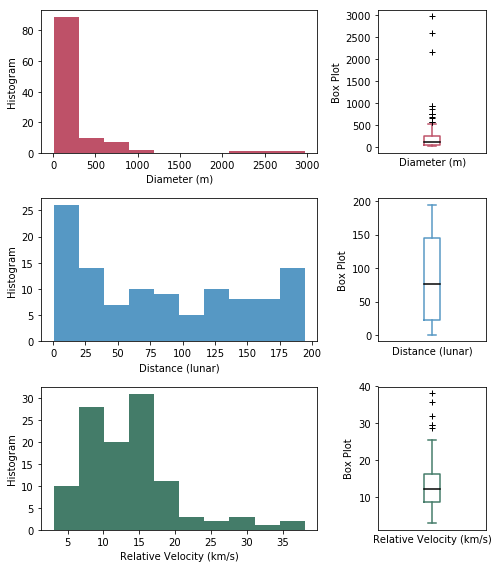

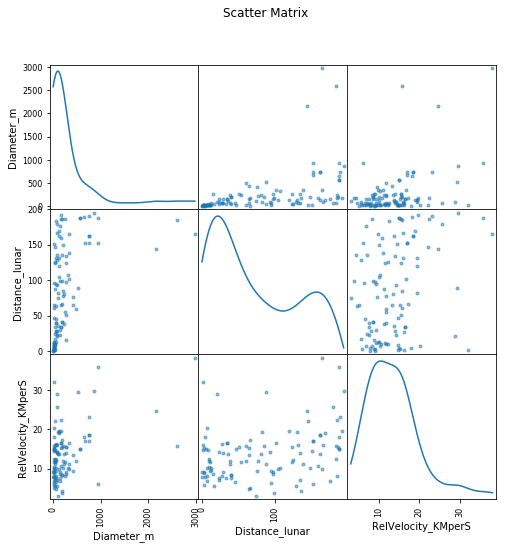

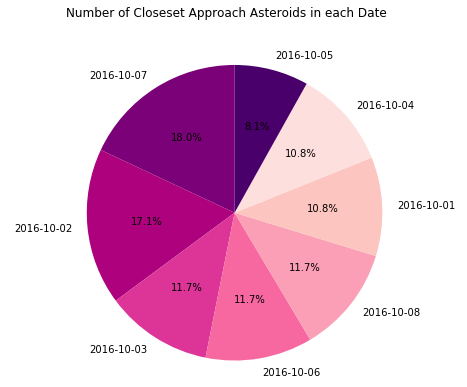

In [13]:
fig=plt.figure()
sliceColors = ['#7a0177','#ae017e','#dd3497','#f768a1','#fa9fb5','#fcc5c0','#fde0dd','#49006a']
df.Close_Approach_Date.value_counts().plot(kind='pie',colors=sliceColors,figsize=(8, 6),startangle=90,autopct='%1.1f%%')
plt.axis('equal')
plt.ylabel('')
plt.suptitle('Number of Closeset Approach Asteroids in each Date',size=12)

plt.show()